# Google Trends

Get popularity of each company in terms of Google Trends

In [95]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from pytrends.request import TrendReq

%matplotlib inline

In [197]:
def get_google_trends_df(kwds, start, end, weight=False, smoothing=False):
    """Return DataFrame with weighting based on Google Trends data"""
    pytrend = TrendReq()
    # pytrend.build_payload(kw_list=kwds, timeframe='all')
    pytrend.build_payload(kw_list=kwds, timeframe='{} {}'.format(start, end))
    df_trends = pytrend.interest_over_time()
    if weight:
        df_trends['total'] = df_trends.sum(axis=1)
        for x in kwds:
            df_trends[x] = df_trends[x] / df_trends['total']
        df_trends.drop('total', axis=1, inplace=True)
    df_trends.drop('isPartial', axis=1, inplace=True)
    if smoothing:
        return df_trends.rolling(12).mean()
    return df_trends

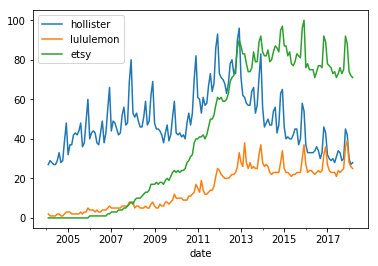

In [56]:
df_trends = get_google_trends_df(['hollister', 'lululemon', 'etsy'])
df_trends.plot.line()

# Intrinio

Get the market capitalization of each company in `df_market_caps`

In [17]:
import requests

In [61]:
url_fmt = "https://api.intrinio.com/historical_data?identifier={}&item=marketcap&start_date={}&end_date={}&frequency={}"
intrinio_user = '8973cc77c9f398dc65258f686f1db27c'
intrinio_pass = '767fe153b9cb32eeb4de646ad106f30c'
frequency = 'monthly'

In [147]:
def get_market_caps_df(kwd_tickers, kwds):
    df_market_caps = None
    for s in kwd_tickers:
        name_ticker_map = dict(zip(kwd_tickers, kwds))
        r = requests.get(url_fmt.format(s, str(start), str(end), frequency),
                     auth=(intrinio_user, intrinio_pass))
        df_cap_cur = pd.DataFrame(r.json()['data'])
        if df_cap_cur.empty:
            raise Exception('No Intrinio data for {}'.format(s))
        df_cap_cur['date'] = pd.to_datetime(df_cap_cur['date'])
        df_cap_cur.set_index('date', inplace=True)

        if s == kwd_tickers[0]:
            df_market_caps = pd.DataFrame(index=df_cap_cur.index)
        df_market_caps[name_ticker_map[s]] = df_cap_cur['value']
    return df_market_caps

## AGGREGATION

next steps:

1. make everything daily
2. subset for common index (weekdays)
3. calculate w for each time point (x/total)
4. do calculation for Y = w*a*b

In [166]:
def get_df_all(df_market_caps, df_trends, kwds, kwd_tickers):
    ticker_name_map = dict(zip(kwds, kwd_tickers))
    df_market_caps = df_market_caps.shift(1, freq='D')
    df_market_caps.fillna(0, inplace=True)
    df_all = df_market_caps.iloc[::-1].join(df_trends, lsuffix='market', rsuffix='trend')
    df_all['weighted_market_cap'] = sum([df_all[name + 'market'] * df_all[name + 'trend'] for name in kwds])
    df_all['unweighted_market_cap'] = sum([df_all[name + 'market'] * 1./len(kwds) for name in kwds])
    return df_all

# Example: Clothing Brands

In [219]:
kwds = ['Hollister', 'Lululemon', 'Aeropostale', 'American Eagle', 'Nordstrom']
kwd_tickers = ['ANF', 'LULU', 'AROPQ', 'AEO', 'JWN']

start = datetime.date(2004, 1, 1)
end = datetime.datetime.now().date()

Setup

In [225]:
from matplotlib.ticker import FuncFormatter
from matplotlib.font_manager import FontProperties

fontP = FontProperties()
fontP.set_size('small')

def billions(x, pos):
    'The two args are the value and tick position'
    return '$%1.1fB' % (x*1e-9)

formatter = FuncFormatter(billions)

Figure 1: raw Google Trends data

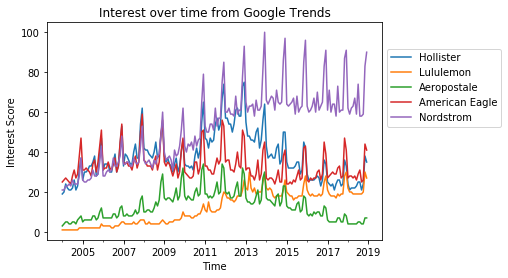

In [234]:
df_trends = get_google_trends_df(kwds, start, end, weight=False)
df_trends.plot.line()
plt.title('Interest over time from Google Trends')
plt.xlabel('Time')
plt.ylabel('Interest Score')
lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.savefig('report/gtrends_clothing.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

Figure 2: smoothed Google Trends data

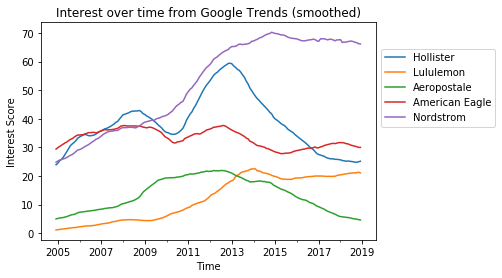

In [233]:
df_trends = get_google_trends_df(kwds, start, end, weight=False, smoothing=True)
df_trends.plot.line()
plt.title('Interest over time from Google Trends (smoothed)')
plt.xlabel('Time')
plt.ylabel('Interest Score')
lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.savefig('report/gtrends_clothing_smooth.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

Figure 3: Weights from Google Trends data

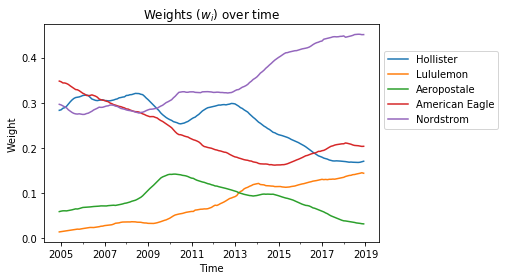

In [230]:
df_trends_weights = get_google_trends_df(kwds, start, end, weight=True, smoothing=True)
df_trends_weights.plot.line()
plt.title('Weights ($w_{i}$) over time')
plt.xlabel('Time')
plt.ylabel('Weight')
lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.savefig('report/weights_clothing_smooth.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

Figure 4: Market Capitalization data

In [145]:
df_market_caps = get_market_caps_df(kwd_tickers, kwds)

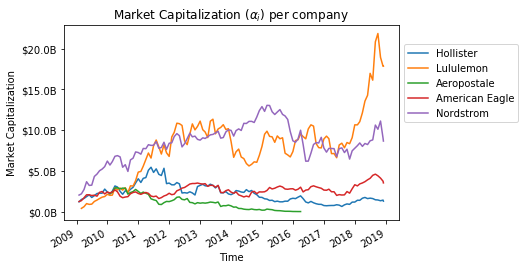

In [231]:
df_market_caps.plot.line()
ax = plt.gca()
ax.yaxis.set_major_formatter(formatter)
plt.title('Market Capitalization ($\\alpha_{i}$) per company')
plt.xlabel('Time')
plt.ylabel('Market Capitalization')
lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.savefig('report/market_clothing.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

Figure 5: Model results

In [206]:
df_all = get_df_all(df_market_caps, df_trends_weights, kwds, kwd_tickers)

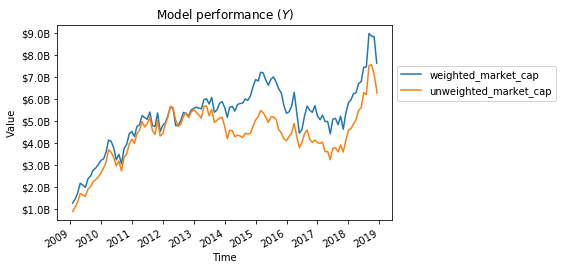

In [232]:
df_all.loc[:,('weighted_market_cap', 'unweighted_market_cap')].plot.line()
ax = plt.gca()
ax.yaxis.set_major_formatter(formatter)
plt.title('Model performance ($Y$)')
plt.xlabel('Time')
plt.ylabel('Value')
lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.savefig('report/model_clothing.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

# Example: `$BASIC`

In [236]:
kwds = ['Apple', 'Ulta', 'Starbucks', 'Nike']
kwd_tickers = ['AAPL', 'ULTA', 'SBUX', 'NKE']

In [238]:
df_trends_weights = get_google_trends_df(kwds, start, end, weight=True, smoothing=True)

In [237]:
df_market_caps = get_market_caps_df(kwd_tickers, kwds)

In [239]:
df_all = get_df_all(df_market_caps, df_trends_weights, kwds, kwd_tickers)

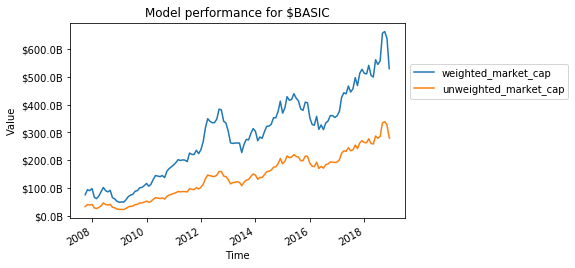

In [241]:
df_all.loc[:,('weighted_market_cap', 'unweighted_market_cap')].plot.line()
ax = plt.gca()
ax.yaxis.set_major_formatter(formatter)
plt.title('Model performance for $BASIC')
plt.xlabel('Time')
plt.ylabel('Value')
lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.savefig('report/model_clothing.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')